In [1]:
!nvidia-smi

Sat Feb 19 21:35:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install libraries

In [2]:
%%capture
!pip install git+https://github.com/huggingface/transformers.git
!pip install flax jsonlines ftfy wandb
!pip install -U tqdm
!pip install git+https://github.com/deepmind/optax.git

In [3]:
%%capture
!git clone https://github.com/INF800/CLIP-rsicd

In [4]:
import sys
sys.path += ['CLIP-rsicd']

## Imports

In [5]:
import jax.tools.colab_tpu
try:
    jax.tools.colab_tpu.setup_tpu()
    half_precision_dtype = "bfloat16"
except KeyError as e:
    half_precision_dtype = "float16"
    print("No TPU detected")

device_count = jax.device_count()
print(device_count)

No TPU detected
1


In [6]:
import logging
import math
import os
import sys
import time
from dataclasses import dataclass, field
from pathlib import Path
from typing import Callable, Optional, List
import json
import jsonlines
import shutil
import numpy as np
import torch

from flax import training
from tqdm.auto import tqdm

import jax
import jax.numpy as jnp
import optax
import transformers
from flax import jax_utils, traverse_util
from flax.jax_utils import unreplicate
from flax.training import train_state
from flax.training.common_utils import get_metrics, onehot, shard, shard_prng_key
from flax.training.checkpoints import save_checkpoint, restore_checkpoint
from flax.serialization import to_bytes, from_bytes
from transformers import (
    CONFIG_MAPPING,
    AutoConfig,
    FlaxCLIPModel,
    CLIPProcessor,
    CLIPTokenizer,
    TrainingArguments,
    is_tensorboard_available,
    IntervalStrategy
    
)
from transformers.testing_utils import CaptureLogger

from importlib.util import find_spec

logger = logging.getLogger(__name__)

In [7]:
from utils.data import ImageTextDataset, Transform

## Data

In this notebook we will be using [RSICD dataset](). A copy of this dataset is shared by the authors on google drive. To use it one can simply add a shrtcut to own gdrive. In my case it's `RSICD` folder.

In [8]:
!pip install --upgrade --no-cache-dir gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.3.0-py3-none-any.whl size=14412 sha256=69ab7da98918083f7a7b1d498e2eb17bac40f59213c31f8a94ed57cec922ee49
  Stored in directory: /tmp/pip-ephem-wheel-cache-rq3l29h0/wheels/fd/ce/f8/389eafb78bce55ea78740dfcafc3c9da6f5e70d25c0377610d
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.1
    Uninstalling gdown-4.2.1:
      Successfully uninstalled gdown-4.2.1


In [9]:
!gdown https://drive.google.com/uc?id=15YDksmpQERDE8aP_jFh2X9D1zuzn2t59

Downloading...
From: https://drive.google.com/uc?id=15YDksmpQERDE8aP_jFh2X9D1zuzn2t59
To: /content/RSICD.zip
100% 483M/483M [00:06<00:00, 73.8MB/s]


In [10]:
# !unzip /content/drive/MyDrive/gen/search_engine/training_data/UCM_captions.zip
!unzip RSICD.zip

Archive:  RSICD.zip
 extracting: RSICD/annotations_rsicd.rar  
 extracting: RSICD/RSICD_images.rar  


In [11]:
root_dir = "/content/"
path = Path(root_dir + 'RSICD/')

In [12]:
%%capture
!unrar x {path}/RSICD_images.rar ./data/

In [13]:
!mv /content/data/RSICD_images/ /content/data/rsicd_images

In [14]:
!rm -rf {path}
!rm -rf RSICD.zip

We'll be using augmented captions for the images. The files containing those are available in our [github repo](). 

In [15]:
#### download annotations

In [16]:
%%capture
!wget -P ./data/ https://raw.githubusercontent.com/arampacha/CLIP-rsicd/master/data/textaug_train_rsicd.jsonl
!wget -P ./data/ https://raw.githubusercontent.com/arampacha/CLIP-rsicd/master/data/textaug_valid_rsicd.jsonl
!wget -P ./data/ https://raw.githubusercontent.com/arampacha/CLIP-rsicd/master/data/textaug_test_rsicd.jsonl

> `/content/data` folder is our dataset folder with images and annotations

Each line in the `jsonl` file has two fields: `filename` and `captions`:

In [17]:
from PIL import Image

filename: rsicd_images/airport_61.jpg



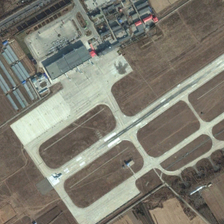

captions:
1) the asphalted and airport runways divide the field into several rounded rectangles arranged next to which buildings and a road are located.
2) the tarmac and airport runways divide the field into several orderly arranged rounded rectangles  next to which is buildings and a road .
3) a brown ground divided by the grey runway .
4) we can see a simple termial building and an apron connceted with runways .
5) some building with a parking lot are near an airport with several runways .



filename: rsicd_images/airport_62.jpg



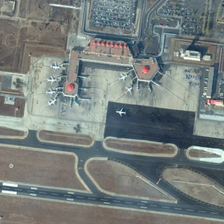

captions:
1) Many white planes are parked at the airport.
2) a motorway is built next to the airport.
3) a highway is built next to the airport .
4) Many white planes are parked at the airport.
5) many white planes are parked at the airport .



filename: rsicd_images/airport_63.jpg



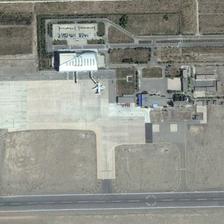

captions:
1) a parking apron with an airplane parked on and connected to a runway is lying on bare ground near which there are some square buildings.
2) a parking apron with a plane parked on and connected to a runway is lying on the bareland  near which there are some square buildings .
3) the airport is between a runway and the farming land .
4) there is a simple termial building with two termial besides the apron which is connected to the runway .
5) a plane is near some buildings and a runway in an airport .



filename: rsicd_images/airport_64.jpg



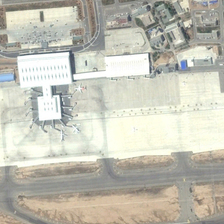

captions:
1) a ploygon terminal is built between a square surrounded by roads and runways built on the ground.
2) a ploygon terminal building is built between a square surrounded by roads and runways built in the field .
3) a square boarding gate next to the runway and some blocks .
4) a squared termial building sits beside an apron which is connceted to the runway .
5) three planes are near a white building in an airport with several runways .





In [18]:
with jsonlines.open("/content/data/textaug_valid_rsicd.jsonl", "r") as reader:
    # line = next(iter(reader))
    for i, line in enumerate(reader):
      if i>3:
        break

      print(f"filename: {line['filename']}\n")
      im = Image.open(f'/content/data/{line["filename"]}')
      display(im)

      print("captions:")
      for i, caption in enumerate(line["captions"]):
          print(f"{i+1}) {caption}")
      print("\n\n")

## Training arguments

In [19]:
@dataclass
class ModelArguments:
    """
    Arguments pertaining to which model/config/tokenizer we are going to fine-tune, or train from scratch.
    """

    model_name_or_path: Optional[str] = field(
        default=None,
        metadata={
            "help": "The model checkpoint for weights initialization."
            "Don't set if you want to train a model from scratch."
        },
    )
    config_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
    )
    tokenizer_name: Optional[str] = field(
        default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
    )
    cache_dir: Optional[str] = field(
        default=None, metadata={"help": "Where do you want to store the pretrained models downloaded from s3"}
    )
    use_fast_tokenizer: bool = field(
        default=True,
        metadata={"help": "Whether to use one of the fast tokenizer (backed by the tokenizers library) or not."},
    )
    dtype: Optional[str] = field(
        default="float32",
        metadata={
            "help": "Floating-point format in which the model weights should be initialized and trained. Choose one of `[float32, float16, bfloat16]`."
        },
    )
    save_optimizer: Optional[bool] = field(
        default=True,
        metadata={"help": "Whether to store full train state including optimizer."},
    )


@dataclass
class DataTrainingArguments:
    """
    Arguments pertaining to what data we are going to input our model for training and eval.
    """

    dataset_name: Optional[str] = field(
        default=None, metadata={"help": "The name of the dataset to use (via the datasets library)."}
    )
    data_dir: Optional[str] = field(
        default=None, metadata={"help": "Path to local folder containing data files."}
    )
    train_file: Optional[str] = field(
        default=None, metadata={"help": "The input training data file (a jsonlines file)."}
    )
    validation_file: Optional[str] = field(
        default=None,
        metadata={"help": "An optional input evaluation data file (a jsonlines file)."},
    )
    train_file: Optional[str] = field(default=None, metadata={"help": "The input training data file (a text file)."})
    validation_file: Optional[str] = field(
        default=None,
        metadata={"help": "An optional input evaluation data file to evaluate the perplexity on (a text file)."},
    )
    max_train_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, truncate the number of training examples to this "
            "value if set."
        },
    )
    max_eval_samples: Optional[int] = field(
        default=None,
        metadata={
            "help": "For debugging purposes or quicker training, truncate the number of evaluation examples to this "
            "value if set."
        },
    )
    overwrite_cache: bool = field(
        default=False, metadata={"help": "Overwrite the cached training and evaluation sets"}
    )
    validation_split_percentage: Optional[int] = field(
        default=5,
        metadata={
            "help": "The percentage of the train set used as validation set in case there's no validation split"
        },
    )
    block_size: Optional[int] = field(
        default=None,
        metadata={
            "help": "Optional input sequence length after tokenization. "
            "The training dataset will be truncated in block of this size for training. "
            "Default to the model max input length for single sentence inputs (take into account special tokens)."
        },
    )
    overwrite_cache: bool = field(
        default=False, metadata={"help": "Overwrite the cached training and evaluation sets"}
    )
    preprocessing_num_workers: Optional[int] = field(
        default=None,
        metadata={"help": "The number of processes to use for the preprocessing."},
    )
    text_column_name: Optional[str] = field(
            default='text',
            metadata={"help": "Column containing main text data."},
    )
    augment_images: Optional[bool] = field(
        default=True,
        metadata={ "help": "Augment input training images" }
    )
    augment_captions: Optional[bool] = field(
        default=True,
        metadata={ "help": "Augment input training images" }
    )
    captions_per_image: Optional[int] = field(
        default=5,
        metadata={"help": "Number of captions per image to use when creating train dataset."},
    )

    def __post_init__(self):
        if self.dataset_name is None and self.train_file is None and self.validation_file is None:
            raise ValueError("Need either a dataset name or a training/validation file.")
        else:
            if self.train_file is not None:
                extension = self.train_file.split(".")[-1]
                assert extension in ["csv", "json", "txt", "jsonl"], "`train_file` should be a csv, a json or a txt file."
            if self.validation_file is not None:
                extension = self.validation_file.split(".")[-1]
                assert extension in ["csv", "json", "txt", "jsonl"], "`validation_file` should be a csv, a json or a txt file."


@dataclass
class ImageAugmentationArguments:
    """
    Arguments for image augmentations configuration
    """
    random_horizontal_flip: Optional[float] = field(
        default=0.5,
        metadata={ "help": "Probability of applying random horizontal flip" }
    )
    random_vertical_flip: Optional[float] = field(
        default=0.5,
        metadata={ "help": "Probability of applying random vartical flip" }
    )


In [38]:
training_args = TrainingArguments(
    output_dir = "./tmp/model1",
    overwrite_output_dir = False,
    do_train = True,
    do_eval = True,
    evaluation_strategy = "steps",
    per_device_train_batch_size = 8, #32,
    per_device_eval_batch_size = 8, #32,
    gradient_accumulation_steps = 8,
    learning_rate = 5e-05,
    weight_decay = 0.1,
    adam_beta1 = 0.9,
    adam_beta2 = 0.98,
    adam_epsilon = 1e-06,
    max_grad_norm = 1.0,
    num_train_epochs = 4, # 1,
    max_steps = -1,
    lr_scheduler_type = "linear",
    warmup_ratio = 0.2,
    # warmup_steps = 0,
    logging_first_step = False,
    logging_steps = 50,
    save_strategy = "epoch",
    seed = 42,
    dataloader_drop_last = True,
    eval_steps = 200,
    run_name = None,
    adafactor = False,
    report_to = "all",
    skip_memory_metrics = True,
    resume_from_checkpoint = None,
)

In [39]:
model_args = ModelArguments(
    model_name_or_path = "openai/clip-vit-base-patch32",
    dtype = half_precision_dtype,
    save_optimizer = False,
)

In [40]:
data_args = DataTrainingArguments(
    dataset_name = None,
    data_dir = "/content/data/",
    train_file = "/content/data/textaug_train_rsicd.jsonl",
    validation_file = "/content/data/textaug_valid_rsicd.jsonl",
    max_train_samples = None,
    max_eval_samples = None,
    overwrite_cache = False,
    validation_split_percentage = 5,
    preprocessing_num_workers = 2,
    augment_images = True,
    augment_captions = True,
    captions_per_image = 5,
)

augmentation_args = ImageAugmentationArguments()

Some utility functions for training:

In [41]:
class TrainState(train_state.TrainState):
    dropout_rng: jnp.ndarray

    def replicate(self):
        return jax_utils.replicate(self).replace(dropout_rng=shard_prng_key(self.dropout_rng))


def write_train_metric(summary_writer, train_metrics, train_time, step):
    summary_writer.scalar("train_time", train_time, step)

    train_metrics = get_metrics(train_metrics)
    for key, vals in train_metrics.items():
        tag = f"train_{key}"
        for i, val in enumerate(vals):
            summary_writer.scalar(tag, val, step - len(vals) + i + 1)


def write_eval_metric(summary_writer, eval_metrics, step):
    for metric_name, value in eval_metrics.items():
        summary_writer.scalar(f"eval_{metric_name}", value, step)


def create_learning_rate_fn(
    train_ds_size: int, train_batch_size: int, num_train_epochs: int, warmup_ratio: float, learning_rate: float
) -> Callable[[int], jnp.array]:
    """Returns a linear warmup, linear_decay learning rate function."""
    steps_per_epoch = train_ds_size // train_batch_size
    num_train_steps = steps_per_epoch * num_train_epochs
    num_warmup_steps = int(num_train_steps * warmup_ratio)
    warmup_fn = optax.linear_schedule(init_value=0.0, end_value=learning_rate, transition_steps=num_warmup_steps)
    decay_fn = optax.linear_schedule(
        init_value=learning_rate, end_value=0, transition_steps=num_train_steps - num_warmup_steps
    )
    schedule_fn = optax.join_schedules(schedules=[warmup_fn, decay_fn], boundaries=[num_warmup_steps])
    return schedule_fn

# utils
def mb_item(x):
    return x.item() if hasattr(x, "item") else x

def make_batch(samples):
    batch = {k:jnp.array(v) for k,v in samples.items()}
    return batch


## Training

In [42]:
# Make one log on every process with the configuration for debugging.
logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)

In [43]:
# Load pretrained model and tokenizer

# Distributed training:
# The .from_pretrained methods guarantee that only one local process can concurrently
# download model & vocab.
if model_args.config_name:
    config = AutoConfig.from_pretrained(model_args.config_name, cache_dir=model_args.cache_dir)
elif model_args.model_name_or_path:
    config = AutoConfig.from_pretrained(model_args.model_name_or_path, cache_dir=model_args.cache_dir)
else:
    config = CONFIG_MAPPING[model_args.model_type]()
    logger.warning("You are instantiating a new config instance from scratch.")

processor = CLIPProcessor.from_pretrained(model_args.model_name_or_path)
tokenizer = processor.tokenizer
if model_args.model_name_or_path:
    model = FlaxCLIPModel.from_pretrained(
        model_args.model_name_or_path, config=config, seed=training_args.seed, dtype=getattr(jnp, model_args.dtype)
    )
else:
    model = FlaxCLIPModel.from_config(
        config, seed=training_args.seed, dtype=getattr(jnp, model_args.dtype)
    )

In [44]:
!ls {data_args.data_dir}

rsicd_images		  textaug_train_rsicd.jsonl
textaug_test_rsicd.jsonl  textaug_valid_rsicd.jsonl


In [45]:
data_args.augment_captions

True

In [46]:
config = model.config
# Initialize torchvision transforms and jit them for faster processing
preprocess = Transform(config.vision_config.image_size, data_args.augment_images, augmentation_args)
preprocess = torch.jit.script(preprocess)

eval_preprocess = Transform(config.vision_config.image_size, False, augmentation_args)
eval_preprocess = torch.jit.script(eval_preprocess)

# Initialize the image-text dataset
train_dataset = ImageTextDataset(
    data_args.data_dir,
    "train",
    captions_per_image=data_args.captions_per_image,
    augment_captions=data_args.augment_captions,
    transform=preprocess,
)

eval_dataset = ImageTextDataset(
    data_args.data_dir,
    "valid",
    captions_per_image=1,
    transform=eval_preprocess,
)

# Enable tensorboard only on the master node
has_tensorboard = is_tensorboard_available()
if has_tensorboard and jax.process_index() == 0:
    try:
        from flax.metrics.tensorboard import SummaryWriter

        summary_writer = SummaryWriter(log_dir=Path(training_args.output_dir))
    except ImportError as ie:
        has_tensorboard = False
        logger.warning(
            f"Unable to display metrics through TensorBoard because some package are not installed: {ie}"
        )
else:
    logger.warning(
        "Unable to display metrics through TensorBoard because the package is not installed: "
        "Please run pip install tensorboard to enable."
    )

# Use collate function to tokenizer the text and convert the processed images to numpy
def collate_fn(examples):
    pixel_values = torch.stack([example[0] for example in examples]).numpy()
    captions = [example[1] for example in examples]
    inputs = tokenizer(captions, max_length=32, padding="max_length", return_tensors="np", truncation=True)

    batch = {
        "pixel_values": pixel_values,
        "input_ids": inputs["input_ids"],
        "attention_mask": inputs["attention_mask"],
    }

    return batch

# Store some constant
num_epochs = int(training_args.num_train_epochs)
train_batch_size = int(training_args.per_device_train_batch_size) * jax.device_count() * training_args.gradient_accumulation_steps
eval_batch_size = int(training_args.per_device_eval_batch_size) * jax.device_count()
steps_per_epoch = len(train_dataset) // train_batch_size
total_train_steps = steps_per_epoch * num_epochs

# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=data_args.preprocessing_num_workers,
    persistent_workers=True,
    drop_last=True,
    collate_fn=collate_fn,
)

eval_loader = torch.utils.data.DataLoader(
    eval_dataset,
    batch_size=eval_batch_size,
    shuffle=False,
    num_workers=data_args.preprocessing_num_workers,
    persistent_workers=True,
    drop_last=True,
    collate_fn=collate_fn,
)


1 input files for train split found
1 input files for valid split found


In [47]:
# enable wandb tracking
has_wandb = find_spec("wandb") is not None 
if jax.process_index() == 0 and has_wandb and ("wandb" in training_args.report_to):
    try:
        import wandb
        if training_args.run_name is None:
            run_name = training_args.output_dir.split("/")[-1]
        else:
            run_name = training_args.run_name
        wandb.init(
            name=run_name,
            entity="wandb", 
            project="hf-flax-clip-rsicd",
            sync_tensorboard=True
        )
        wandb.config.update(training_args)
        wandb.config.update(model_args)
        wandb.config.update(data_args)
    except ImportError as e:
        print(e)
        has_wandb = False

# Initialize our training
rng = jax.random.PRNGKey(training_args.seed)
rng, dropout_rng = jax.random.split(rng)

# Create learning rate schedule
linear_decay_lr_schedule_fn = create_learning_rate_fn(
    len(train_dataset),
    train_batch_size,
    training_args.num_train_epochs,
    training_args.warmup_ratio,
    training_args.learning_rate,
)

# We use Optax's "masking" functionality to not apply weight decay
# to bias and LayerNorm scale parameters. decay_mask_fn returns a
# mask boolean with the same structure as the parameters.
# The mask is True for parameters that should be decayed.
# Note that this mask is specifically adapted for FlaxGPT2.
# For other models, one should correct the layer norm parameter naming
# accordingly.
def decay_mask_fn(params):
    flat_params = traverse_util.flatten_dict(params)
    flat_mask = {
        path: (path[-1] != "bias" and path[-2:] not in [("ln_1", "scale"), ("ln_2", "scale"), ("ln_f", "scale")])
        for path in flat_params
    }
    return traverse_util.unflatten_dict(flat_mask)

# create optimizer
if training_args.adafactor:
    # We use the default parameters here to initialize adafactor,
    # For more details about the parameters please check https://github.com/deepmind/optax/blob/ed02befef9bf81cbbf236be3d2b0e032e9ed4a40/optax/_src/alias.py#L74
    optimizer = optax.adafactor(
        learning_rate=linear_decay_lr_schedule_fn,
    )
else:
    optimizer = optax.adamw(
        learning_rate=linear_decay_lr_schedule_fn,
        b1=training_args.adam_beta1,
        b2=training_args.adam_beta2,
        eps=training_args.adam_epsilon,
        weight_decay=training_args.weight_decay,
        mask=decay_mask_fn,
    )
    optimizer = optax.chain(
        optax.clip_by_global_norm(training_args.max_grad_norm),
        optimizer
    )
if training_args.gradient_accumulation_steps > 1:
    optimizer = optax.MultiSteps(optimizer, training_args.gradient_accumulation_steps)
grad_accum_steps = training_args.gradient_accumulation_steps

# Setup train state
state = TrainState.create(apply_fn=model.__call__, params=model.params, tx=optimizer, dropout_rng=dropout_rng)

if training_args.resume_from_checkpoint:
    state = restore_checkpoint(training_args.resume_from_checkpoint, state)
    resume_step = mb_item(state.step)
else:
    resume_step = 0

In [48]:
def cross_entropy(logits, axis):
    logprobs = jax.nn.log_softmax(logits, axis=axis)
    nll = jnp.diag(logprobs)
    ce = -jnp.mean(nll)
    return ce

def clip_loss(similarity):
    loss = (cross_entropy(similarity, axis=0) + cross_entropy(similarity, axis=1)) / 2
    return loss

# Define gradient update step fn
def train_step(state, batch):
    dropout_rng, new_dropout_rng = jax.random.split(state.dropout_rng)

    def compute_loss(params):
        logits = state.apply_fn(**batch, params=params, dropout_rng=dropout_rng, train=True)[0]
        loss = clip_loss(logits)
        return loss

    grad_fn = jax.value_and_grad(compute_loss)
    loss, grad = grad_fn(state.params)
    grad = jax.lax.pmean(grad, "batch")

    new_state = state.apply_gradients(grads=grad, dropout_rng=new_dropout_rng)

    metrics = {"loss": loss, "learning_rate": linear_decay_lr_schedule_fn(state.step // grad_accum_steps)}
    metrics = jax.lax.pmean(metrics, axis_name="batch")

    return new_state, metrics

# Define eval fn
def eval_step(params, batch):
    logits = model(**batch, params=params, train=False)[0]
    loss = clip_loss(logits)

    # summarize metrics
    metrics = {"loss": loss}
    metrics = jax.lax.pmean(metrics, axis_name="batch")
    return metrics

# Create parallel version of the train and eval step
p_train_step = jax.pmap(train_step, "batch", donate_argnums=(0,))
p_eval_step = jax.pmap(eval_step, "batch")

# Replicate the train state on each device
state = state.replicate()

In [ ]:
logger.info("***** Running training *****")
logger.info(f"  Num examples = {len(train_dataset)}")
logger.info(f"  Num Epochs = {num_epochs}")
logger.info(f"  Instantaneous batch size per device = {training_args.per_device_train_batch_size}")
logger.info(f"  Total train batch size (w. parallel, distributed and grad_accum) = {train_batch_size}")
logger.info(f"  Total optimization steps = {total_train_steps}")

if not training_args.skip_memory_metrics:
    server = jax.profiler.start_server(9999)

train_time = 0
train_metrics = []
epochs = tqdm(range(num_epochs), desc=f"Epoch ... (1/{num_epochs})", position=0)
for epoch in epochs:
    # ======================== Training ================================
    train_start = time.time()

    # Create sampling rng
    rng, input_rng = jax.random.split(rng)

    # Generate an epoch by shuffling sampling indices from the train dataset
    steps_per_epoch = len(train_dataset) // train_batch_size
    # train
    steps_trained_progress_bar = tqdm(range(steps_per_epoch), desc="Training...", position=1,
                                        leave=False, initial=(resume_step // grad_accum_steps))
    for step, batch in enumerate(train_loader):
        cur_step = epoch * (len(train_dataset) // train_batch_size) + step
        # skip to the step from which we are resuming
        if cur_step < resume_step:
            continue
        
        batch = shard(make_batch(batch))
        
        state, train_metric = p_train_step(state, batch)
        train_metrics.append(train_metric)
        if step % grad_accum_steps == 0:
            steps_trained_progress_bar.update(1)

        if cur_step % (training_args.logging_steps * grad_accum_steps)== 0 and cur_step > 0:
            # Save metrics
            train_metric = unreplicate(train_metric)
            train_time += time.time() - train_start
            if has_tensorboard and jax.process_index() == 0:
                write_train_metric(summary_writer, train_metrics, train_time, cur_step)
            if has_wandb and jax.process_index() == 0 and ("wandb" in training_args.report_to):
                # TODO: add accumulation of metrics
                _metrics = {k if k=="learning_rate" else f"train_{k}":mb_item(v.mean()) for k, v in train_metric.items()}
                wandb.log({"training_step":cur_step, **_metrics}, commit=True)

            epochs.write(
                f"Step... ({cur_step} | Loss: {train_metric['loss'].mean()}, Learning Rate: {train_metric['learning_rate'].mean()})"
            )

            train_metrics = []

    if True:
        # ======================== Evaluating ==============================
        eval_metrics = []
        eval_steps = len(eval_dataset) // eval_batch_size
        for batch in tqdm(eval_loader, desc="Evaluating...", position=2, leave=False):
            # Model forward
            batch = shard(make_batch(batch))
            metrics = p_eval_step(state.params, batch)
            eval_metrics.append(metrics)

        # normalize eval metrics
        eval_metrics = get_metrics(eval_metrics)
        eval_metrics = jax.tree_map(jnp.mean, eval_metrics)

        # Print metrics and update progress bar
        desc = f"Step... ({cur_step} | Eval Loss: {eval_metrics['loss']})"
        epochs.write(desc)
        epochs.desc = desc

        # Save metrics
        if has_tensorboard and jax.process_index() == 0:
            # cur_step = epoch * (len(train_dataset) // train_batch_size)
            write_eval_metric(summary_writer, eval_metrics, cur_step)
        if has_wandb and jax.process_index() == 0 and ("wandb" in training_args.report_to):
            _metrics = {f"eval_{k}":mb_item(v) for k, v in eval_metrics.items()}
            wandb.log({"eval_step":cur_step, **_metrics})

    # save checkpoint after each epoch
    if jax.process_index() == 0:
        save_dir = f"{training_args.output_dir}/ckpt-{epoch}"
        model.save_pretrained(
            save_dir,
            params=unreplicate(state.params),
            push_to_hub=False, # training_args.push_to_hub, # we don't push intermediate steps
            commit_message=f"Saving weights and logs at epoch {epoch}",
            repo_name_or_path=training_args.output_dir
        )
        if model_args.save_optimizer:
            save_checkpoint(training_args.output_dir, unreplicate(state), cur_step, keep=training_args.save_total_limit, overwrite=True)
        if training_args.save_total_limit is not None:
            rotate_checkpoints(training_args.output_dir, training_args.save_total_limit)


Epoch ... (1/4):   0%|          | 0/4 [00:00<?, ?it/s]

Training...:   0%|          | 0/682 [00:00<?, ?it/s]

Step... (400 | Loss: 1.48323392868042, Learning Rate: 4.587156581692398e-06)


Evaluating...:   0%|          | 0/136 [00:00<?, ?it/s]

Step... (681 | Eval Loss: 2.1495909690856934)


Training...:   0%|          | 0/682 [00:00<?, ?it/s]

Step... (800 | Loss: 1.1081550121307373, Learning Rate: 9.174309525405988e-06)
Step... (1200 | Loss: 0.8733930587768555, Learning Rate: 1.3761466107098386e-05)


Evaluating...:   0%|          | 0/136 [00:00<?, ?it/s]

Step... (1363 | Eval Loss: 2.254059314727783)


Training...:   0%|          | 0/682 [00:00<?, ?it/s]

Step... (1600 | Loss: 0.7793260812759399, Learning Rate: 1.8348622688790783e-05)
Step... (2000 | Loss: 0.6138656139373779, Learning Rate: 2.2935777451493777e-05)


Evaluating...:   0%|          | 0/136 [00:00<?, ?it/s]

Step... (2045 | Eval Loss: 2.3446433544158936)


Training...:   0%|          | 0/682 [00:00<?, ?it/s]

Step... (2400 | Loss: 0.5676295757293701, Learning Rate: 2.752293585217558e-05)


In [ ]:
!zip -r model1.zip tmp

In [ ]:
#### ORIGINAL NOTEBOOK RESULTS

# INFO:__main__:***** Running training *****
# INFO:__main__:  Num examples = 43670
# INFO:__main__:  Num Epochs = 1
# INFO:__main__:  Instantaneous batch size per device = 32
# INFO:__main__:  Total train batch size (w. parallel, distributed and grad_accum) = 32
# INFO:__main__:  Total optimization steps = 1364
# Step... (1363 | Eval Loss: 3.2465083599090576): 100%
# 1/1 [07:00<00:00, 420.12s/it]
# Training...: 100%
# 1364/1364 [06:55<00:00, 5.38it/s]
# Step... (50 | Loss: 1.3779796361923218, Learning Rate: 9.191175195155665e-06)
# Step... (100 | Loss: 1.1074166297912598, Learning Rate: 1.838235039031133e-05)
# Step... (150 | Loss: 1.2220288515090942, Learning Rate: 2.75735274044564e-05)
# Step... (200 | Loss: 1.0351999998092651, Learning Rate: 3.676470441860147e-05)
# Step... (250 | Loss: 1.1444642543792725, Learning Rate: 4.5955879613757133e-05)
# Step... (300 | Loss: 1.1477177143096924, Learning Rate: 4.871794590144418e-05)
# Step... (350 | Loss: 0.7504262924194336, Learning Rate: 4.6428569476120174e-05)
# Step... (400 | Loss: 1.0174486637115479, Learning Rate: 4.4139193050796166e-05)
# Step... (450 | Loss: 0.7156405448913574, Learning Rate: 4.184981298749335e-05)
# Step... (500 | Loss: 1.2542169094085693, Learning Rate: 3.956044020014815e-05)
# Step... (550 | Loss: 0.4042561650276184, Learning Rate: 3.7271060136845335e-05)
# Step... (600 | Loss: 0.8942058682441711, Learning Rate: 3.498168371152133e-05)
# Step... (650 | Loss: 0.9672960042953491, Learning Rate: 3.269230728619732e-05)
# Step... (700 | Loss: 0.9689963459968567, Learning Rate: 3.0402927222894505e-05)
# Step... (750 | Loss: 0.7871372699737549, Learning Rate: 2.81135526165599e-05)
# Step... (800 | Loss: 0.5602303743362427, Learning Rate: 2.5824176191235892e-05)
# Step... (850 | Loss: 0.8040098547935486, Learning Rate: 2.353479794692248e-05)
# Step... (900 | Loss: 0.4087825417518616, Learning Rate: 2.124541970260907e-05)
# Step... (950 | Loss: 0.8836148977279663, Learning Rate: 1.8956043277285062e-05)
# Step... (1000 | Loss: 0.6022820472717285, Learning Rate: 1.666666503297165e-05)
# Step... (1050 | Loss: 0.5808299779891968, Learning Rate: 1.4377289517142344e-05)
# Step... (1100 | Loss: 0.873551607131958, Learning Rate: 1.2087911272828933e-05)
# Step... (1150 | Loss: 0.44037193059921265, Learning Rate: 9.798535756999627e-06)
# Step... (1200 | Loss: 0.38650739192962646, Learning Rate: 7.5091570579388645e-06)
# Step... (1250 | Loss: 0.433038592338562, Learning Rate: 5.2197810873622075e-06)
# Step... (1300 | Loss: 0.4083743095397949, Learning Rate: 2.9304026156751206e-06)
# Step... (1350 | Loss: 0.5199722051620483, Learning Rate: 6.410240871446149e-07)
# Evaluating...: 97%
# 33/34 [00:16<00:00, 9.17it/s]
# Step... (1363 | Eval Loss: 3.2465083599090576)

In [ ]:
# compare the above training results.
# in original, loss decreases, increases and then again decreases.